In [1]:
pip install pandas_ta

Note: you may need to restart the kernel to use updated packages.


# Data Preparation
In this step will include the following steps:


1. Data Preprocessing: Remove NULL data
2. Featuring Engineer: Create Data Features
3. Target or Label Definition: Define target of the model
4. Training dataset








In [2]:
##Import Libraries for Data processing

# Data Manipulation
import numpy as np
import pandas as pd

#Datasource
import yfinance as yf

#Data Features
from pandas_ta import Imports

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data Normalization
from sklearn.preprocessing import MinMaxScaler

np.random.seed(0)

## Data preparation Code

In [3]:
class Dataset:
  ## 1. Data preprocessing
  def __init__(self, tickers, start_date, end_date):
    #  """
    #     Initializes the Dataset class with provided tickers, start date, and end date.

    #     Args:
    #         tickers (list): List of strings representing the tickers of assets.
    #         start_date (str): Start date of the historical data (format: 'YYYY-MM-DD').
    #         end_date (str): End date of the historical data (format: 'YYYY-MM-DD').

    #     Attributes:
    #         tickers (list): List of strings representing the tickers of assets.
    #         start_date (str): Start date of the historical data.
    #         end_date (str): End date of the historical data.
    #         data (DataFrame): DataFrame containing historical data for the specified tickers
    #             within the specified time period.

    #     Returns:
    #         None
    #   """
      self.tickers = tickers
      self.start_date = start_date
      self.end_date = end_date

      # Download historical data from the designated ticker list
      self.data = self._download(tickers, start_date, end_date)

      # Clean the downloaded data
      self.data = self._clean(self.data)

      # Add cash column
      self.data = self._add_cash(self.data)

  def _download(self, tickers, start_date, end_date):
        """
        Downloads historical financial data using Yahoo Finance API.

        Args:
            tickers (list): List of strings representing the tickers of assets.
            start_date (str): Start date of the historical data.
            end_date (str): End date of the historical data.

        Returns:
            DataFrame: DataFrame containing downloaded historical financial data.
        """
        return yf.download(tickers, start=start_date, end=end_date)

  def _clean(self, df):
        """
        Cleans the DataFrame by filling missing values and dropping rows with NaN values.

        Args:
            df (DataFrame): DataFrame containing historical financial data.

        Returns:
            DataFrame: Cleaned DataFrame.
        """
        return df.fillna(method='ffill').dropna()

  def _add_cash(self, df, daily_rates=.01/365):
        """
        Adds cash data to the DataFrame.

        Args:
            df (DataFrame): DataFrame containing historical financial data.
            daily_rates (float): Daily interest rate for cash.

        Returns:
            DataFrame: DataFrame with cash data added.
        """
        cash = (pd.Series(1, index=df.index) * (1+daily_rates)).cumprod()
        columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        df_cash = pd.DataFrame({(c,'CASH'): cash for c in columns})
        df_cash.columns = pd.MultiIndex.from_tuples(df_cash.columns)
        return pd.concat([df, df_cash], axis=1)

    ## 2. Featuring Engineer
  def features(self, stoch_lookback=15, scale=True):
        """
        Extracts features from the dataset for model training.

        Args:
            stoch_lookback (int): Lookback period for Stochastic Oscillator calculation.
            scale (bool): Whether to scale the extracted features.

        Returns:
            DataFrame: DataFrame containing features extracted from the dataset.
        """
        df = self.data.swaplevel(0, 1, 1)

        scale_min = 0.01
        scale_max = 1.00

        # Feature extraction for each ticker
        # (RSI, MACD, Bollinger Bands, Stochastic Oscillator, OBV)
        for ticker in df.columns.levels[0]:

            # Relative Strength Index (RSI)
            rsi = df[ticker].ta.rsi()
            rsi = pd.DataFrame(rsi.values, index=rsi.index, columns=['RSI'])
            rsi = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(rsi), index=rsi.index, columns=rsi.columns)
            df[(ticker,'RSI')] = rsi

            # Moving Average Convergence Divergence (MACD)
            macd = df[ticker].ta.macd()
            macd = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(macd), index=macd.index, columns=macd.columns)
            for c in macd.columns:
                df[(ticker, c)] = macd[c]

            # Bollinger Bands
            bbands = df[ticker].ta.bbands()
            bbands = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(bbands), index=bbands.index, columns=bbands.columns)
            for c in bbands.columns:
                df[(ticker, c)] = bbands[c]

            # Stochastic Oscillator
            stoch = df[ticker].ta.stoch(append=True)
            stoch = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(stoch), index=stoch.index, columns=stoch.columns)
            for c in stoch.columns:
                df[(ticker, c)] = stoch[c]

            # On Balance Volume (OBV) including minmax scaling if scale=True
            obv = df[ticker].ta.obv()
            obv = pd.DataFrame(obv.values, index=obv.index, columns=['OBV'])
            obv = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(obv), index=obv.index, columns=obv.columns)
            df[(ticker,'OBV')] = obv
        return df.ffill().dropna(axis=0).swaplevel(0, 1, 1)

    ## 3. Target or label definition
  def targets(self, df, prediction_period):
        """
        Generates target labels for model training.

        Args:
            df (DataFrame): DataFrame containing historical financial data.
            prediction_period (int): Number of days into the future for predicting returns.

        Returns:
            DataFrame: DataFrame containing target labels.
        """
        period_returns = (df['Adj Close'] / df['Adj Close'].shift(prediction_period)) - 1
        period_returns[period_returns < 0] = 0
        weights = period_returns.div(period_returns.sum(axis=1), axis=0)
        weights = weights.fillna(0)
        weights = weights.shift(-1*prediction_period)
        return weights.ffill().round(5)

    ## 4. Create Training Dataset
  def create_training_set(self, features, targets, lookback, dayofweek=4):
        """
        Creates a training set for model training.

        Args:
            features (DataFrame): DataFrame containing features extracted from the dataset.
            targets (DataFrame): DataFrame containing target labels.
            lookback (int): Lookback period for training data.
            dayofweek (int): Day of the week for rebalancing (default: Friday).

        Returns:
            tuple: Tuple containing training data, target labels, closing prices, and dates.
        """

        closes = features['Adj Close']
        print('---- Creating Training Set')
        print(features.shape)
        print(targets.shape)
        print(closes.shape)

        X, y, y_price, y_date = [], [], [], []
        for i in range(len(features)-lookback):
            if features.index[i].dayofweek == dayofweek: # Friday
                X.append(features[i:i+lookback])
                y.append(targets[i+lookback:i+lookback+1])
                y_price.append(closes[i+lookback:i+lookback+1])
                y_date.append(closes.index[i+lookback])

        y_price = pd.DataFrame(index=np.array(y_date), data=np.array(y_price).reshape(len(y_price), targets.shape[1]), columns=closes.columns)
        return np.array(X), np.array(y).reshape(len(y), targets.shape[1]), y_price

In [4]:
def load_train_test(tickers, start, end, lookback_period=10, rebalance_period=5):
    """
    Preparing datasets for model training and evaluation.

    Args:
        tickers (list): List of strings representing the tickers of assets.
        start (str): Start date of the historical data (format: 'YYYY-MM-DD').
        end (str): End date of the historical data (format: 'YYYY-MM-DD').
        lookback_period (int): Lookback period for training data (default: 10).
        rebalance_period (int): Rebalance period for generating target labels (default: 5).

    Returns:
        tuple: Tuple containing training and testing datasets.
            - dataset.data: DataFrame containing historical financial data.
            - features: DataFrame containing extracted features for training.
            - targets: DataFrame containing target labels for training.
            - X: numpy array of training data (features).
            - y: numpy array of target labels.
            - y_price: DataFrame containing closing prices for target labels.
    """
    dataset = Dataset(tickers, start, end)
    features = dataset.features(scale=True)
    targets = dataset.targets(features, rebalance_period)
    X, y, y_price = dataset.create_training_set(features, targets, lookback_period)

    return dataset.data, features, targets, X.astype(np.float32), y.astype(np.float32), y_price

## Datasets for model training and testing

In [5]:
# Define the ticker asset for training model
tickers = ['V', 'GOOGL', 'T', 'JNJ', 'DIS']

# Define the start and end dates for historical data retrieval
start = '2013-01-01'
end = '2023-12-31'

# Load ticker with start and end dates to create datasets for model training and evaluation
# Returns: historical financial data, extracted features, target labels, training data (features), target labels, and closing prices
yfdata, features, targets, X, y, y_price = load_train_test(tickers, start, end)

print('========= Original Dataset =========')
print('features', features.shape, 'columns', features.index[0], features.index[-1])
print('targets', targets.shape, 'columns', targets.index[0], targets.index[-1])
print('X', X.shape)
print('y', y.shape)
print('y_price', y_price.shape)

/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*******************   40%%                      ]  2 of 5 completed/opt/ha/capstone/env/lib/python3.9/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/ha/capstone/env/lib/python3.9/site-packages/yfina

---- Creating Training Set
(2735, 108)
(2735, 6)
(2735, 6)
========= Original Dataset =========
features (2735, 108) columns 2013-02-20 00:00:00 2023-12-29 00:00:00
targets (2735, 6) columns 2013-02-20 00:00:00 2023-12-29 00:00:00
X (545, 10, 108)
y (545, 6)
y_price (545, 6)


## Descriptive Statistic of datasets


*   Datasource
*   Feature Dataset
*   Target Dataset



In [6]:
# Datasource
yfdata.describe()

Adj Close                                                      \
               DIS        GOOGL          JNJ            T            V   
count  2768.000000  2768.000000  2768.000000  2768.000000  2768.000000   
mean    106.483973    64.871960   114.321133    15.773751   132.718137   
std      31.291157    37.461635    33.262270     2.327507    68.604836   
min      45.832546    17.589338    51.901596    11.069024    35.789112   
25%      88.768764    34.047874    81.327785    13.598673    67.869558   
50%     100.858437    54.473999   113.763424    16.154954   128.065960   
75%     116.958822    93.880001   148.319218    17.410794   201.266850   
max     201.254089   149.838501   175.705063    21.439383   261.891663   

             Close                                                      ...  \
               DIS        GOOGL          JNJ            T            V  ...   
count  2768.000000  2768.000000  2768.000000  2768.000000  2768.000000  ...   
mean    109.756629    64.871960   131.038465    24.357528   136.680955  ...   
std      29.785210    37.461635    28.101667     4.272476    68.430793  ...   
min      50.580002    17.589338    70.739998    13.450000    38.692501  ...   
25%      92.659998    34.047874   104.037500    21.638973    71.902502  ...   
50%     105.169998    54.473999   132.044998    25.245468   132.894997  ...   
75%     118.662502    93.880001   155.062500    27.328173   205.132504  ...   
max     201.910004   149.838501   186.009995    32.832325   262.380005  ...   

             Volume                                                   Open  \
              GOOGL           JNJ             T             V         CASH   
count  2.768000e+03  2.768000e+03  2.768000e+03  2.768000e+03  2768.000000   
mean   4.192169e+07  7.863767e+06  4.131583e+07  8.982382e+06     1.038908   
std    2.621707e+07  5.814773e+06  2.211364e+07  4.894756e+06     0.022746   
min    9.312000e+06  2.114900e+06  9.085818e+06  1.640900e+06     1.000027   
25%    2.654850e+07  5.656850e+06  2.774327e+07  6.100700e+06     1.019160   
50%    3.386400e+07  6.896900e+06  3.610151e+07  7.836200e+06     1.038660   
75%    4.752900e+07  8.672125e+06  4.770402e+07  1.054868e+07     1.058532   
max    4.621933e+08  1.513195e+08  3.270974e+08  9.007360e+07     1.078784   

              High          Low        Close    Adj Close       Volume  
              CASH         CASH         CASH         CASH         CASH  
count  2768.000000  2768.000000  2768.000000  2768.000000  2768.000000  
mean      1.038908     1.038908     1.038908     1.038908     1.038908  
std       0.022746     0.022746     0.022746     0.022746     0.022746  
min       1.000027     1.000027     1.000027     1.000027     1.000027  
25%       1.019160     1.019160     1.019160     1.019160     1.019160  
50%       1.038660     1.038660     1.038660     1.038660     1.038660  
75%       1.058532     1.058532     1.058532     1.058532     1.058532  
max       1.078784     1.078784     1.078784     1.078784     1.078784  

[8 rows x 36 columns]

In [7]:
# Feature Dataset
features.describe()

Adj Close                                                      \
               DIS        GOOGL          JNJ            T            V   
count  2735.000000  2735.000000  2735.000000  2735.000000  2735.000000   
mean    107.187478    65.427946   115.048868    15.824977   133.878620   
std      30.812317    37.341258    32.791415     2.293860    68.194050   
min      48.560028    19.166918    55.888859    11.367671    35.959476   
25%      89.635685    35.228500    81.855297    13.652244    69.327496   
50%     101.141533    54.787998   114.353004    16.185965   129.671432   
75%     117.646576    94.590000   148.657677    17.418939   201.653793   
max     201.254089   149.838501   175.705063    21.439383   261.891663   

             Close                                                      ...  \
               DIS        GOOGL          JNJ            T            V  ...   
count  2735.000000  2735.000000  2735.000000  2735.000000  2735.000000  ...   
mean    110.439408    65.427946   131.731386    24.335659   137.852869  ...   
std      29.303852    37.341258    27.548405     4.293066    68.000389  ...   
min      53.590000    19.166918    75.570000    13.450000    38.855000  ...   
25%      93.130001    35.228500   104.670002    21.608761    73.470001  ...   
50%     105.360001    54.787998   132.320007    25.203926   134.759995  ...   
75%     118.970001    94.590000   155.514999    27.364048   205.540001  ...   
max     201.910004   149.838501   186.009995    32.832325   262.380005  ...   

      MACDh_12_26_9 MACDs_12_26_9    BBL_5_2.0    BBM_5_2.0    BBU_5_2.0  \
                  V             V            V            V            V   
count   2735.000000   2735.000000  2735.000000  2735.000000  2735.000000   
mean       0.525405      0.703738     0.444089     0.452896     0.457450   
std        0.101731      0.109611     0.299347     0.305152     0.307931   
min        0.010000      0.010000     0.010186     0.010020     0.010580   
25%        0.490195      0.661372     0.158676     0.162958     0.166382   
50%        0.525103      0.707646     0.427472     0.439577     0.444175   
75%        0.565362      0.758835     0.735665     0.756394     0.769685   
max        1.000000      1.000000     1.000000     1.000000     1.000000   

         BBB_5_2.0    BBP_5_2.0 STOCHk_14_3_3 STOCHd_14_3_3          OBV  
                 V            V             V             V            V  
count  2735.000000  2735.000000   2735.000000   2735.000000  2735.000000  
mean      0.139779     0.547688      0.610603      0.608568     0.580826  
std       0.102666     0.279272      0.268823      0.269959     0.302459  
min       0.010000     0.010000      0.010000      0.010000     0.014626  
25%       0.074273     0.295127      0.386714      0.386109     0.293214  
50%       0.112472     0.592968      0.661691      0.655199     0.651670  
75%       0.175349     0.795314      0.852736      0.852806     0.864757  
max       1.000000     1.000000      1.000000      1.000000     1.000000  

[8 rows x 108 columns]

In [8]:
# Target Dataset
targets.describe()

,DIS,GOOGL,JNJ,T,V,CASH
count,2735.000000,2735.000000,2735.000000,2735.000000,2735.000000,2735.000000
mean,0.164836,0.202971,0.164146,0.172598,0.181549,0.113898
std,0.228520,0.253978,0.242118,0.253166,0.230418,0.306017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000170
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.001520
50%,0.046640,0.101290,0.044960,0.040930,0.107150,0.002840
75%,0.270990,0.338165,0.245175,0.253795,0.286060,0.008555
max,0.998960,0.998790,0.998470,0.998710,0.998030,1.000000


## Exploratory Data Analysis (EDA)

### Price Correlation of each stock

In [9]:
# get adjusted close price from historical dataset
stock_data = yfdata['Adj Close']

# remove unrelated column [CASH column]
stock_data = stock_data.drop(['CASH'], axis=1)

# show data
stock_data.head()

,DIS,GOOGL,JNJ,T,V
Date,,,,,
2013-01-02,46.303738,18.099348,51.974960,11.472700,35.874550
2013-01-03,46.403412,18.109859,51.901596,11.479257,35.902252
2013-01-04,47.291424,18.467718,52.495888,11.548092,36.195480
2013-01-07,46.185940,18.387136,52.385834,11.600537,36.454056
2013-01-08,45.995647,18.350851,52.393166,11.452439,36.793453


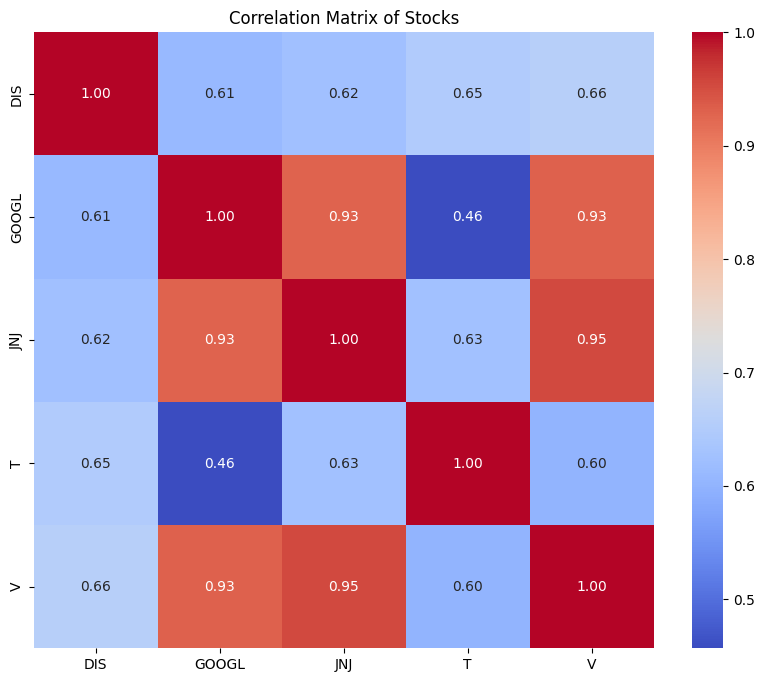

In [10]:
# Compute the correlation matrix
correlation_matrix = stock_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix of Stocks')
plt.show()

### Feature correlation of each stock

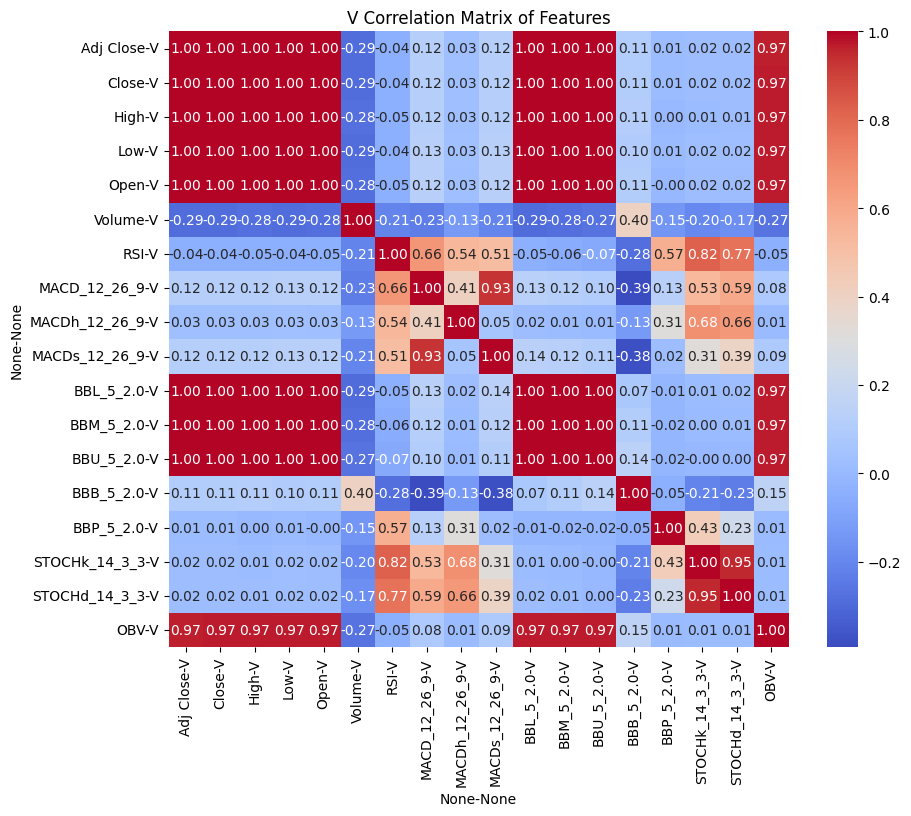

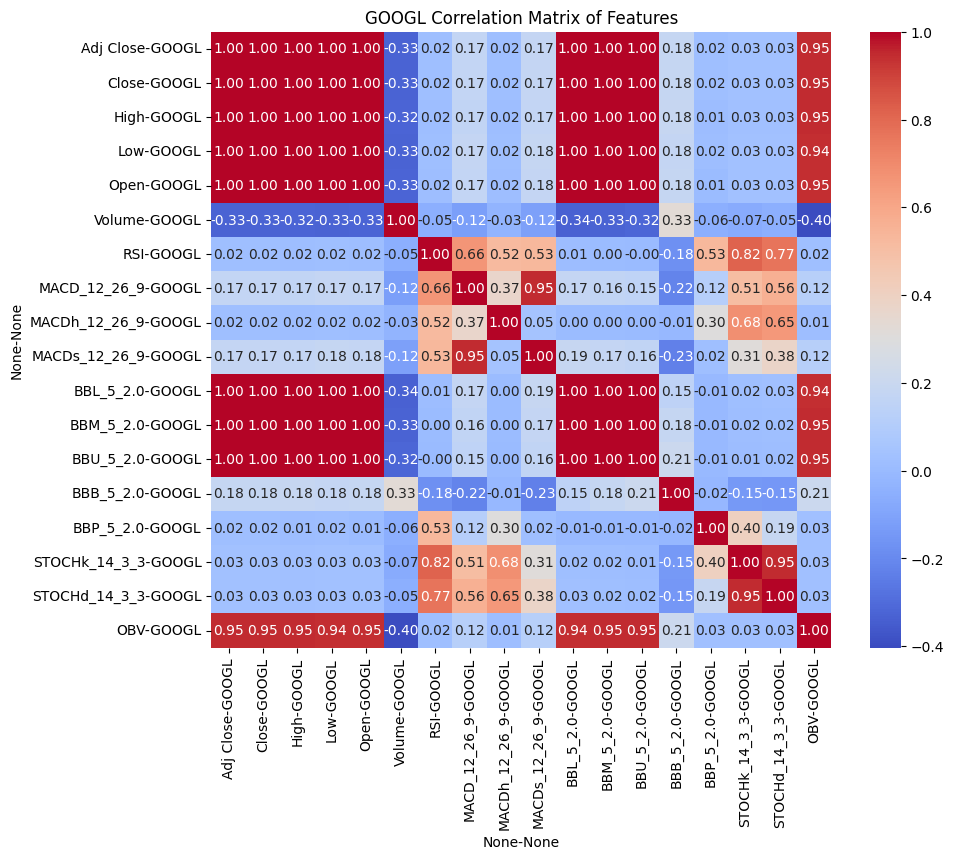

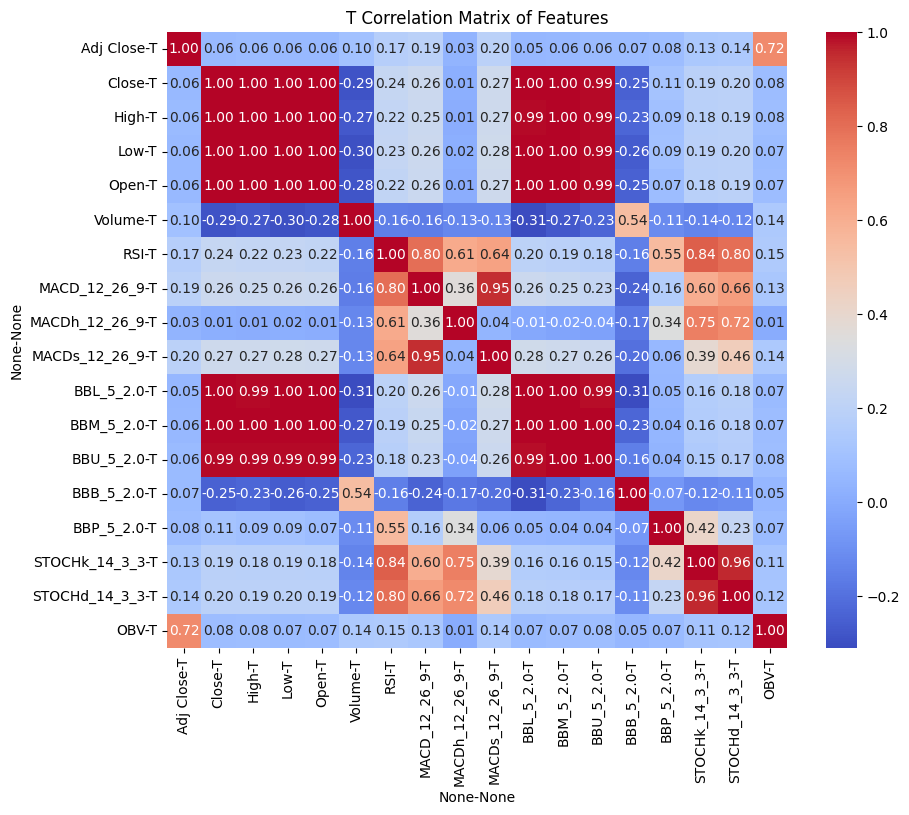

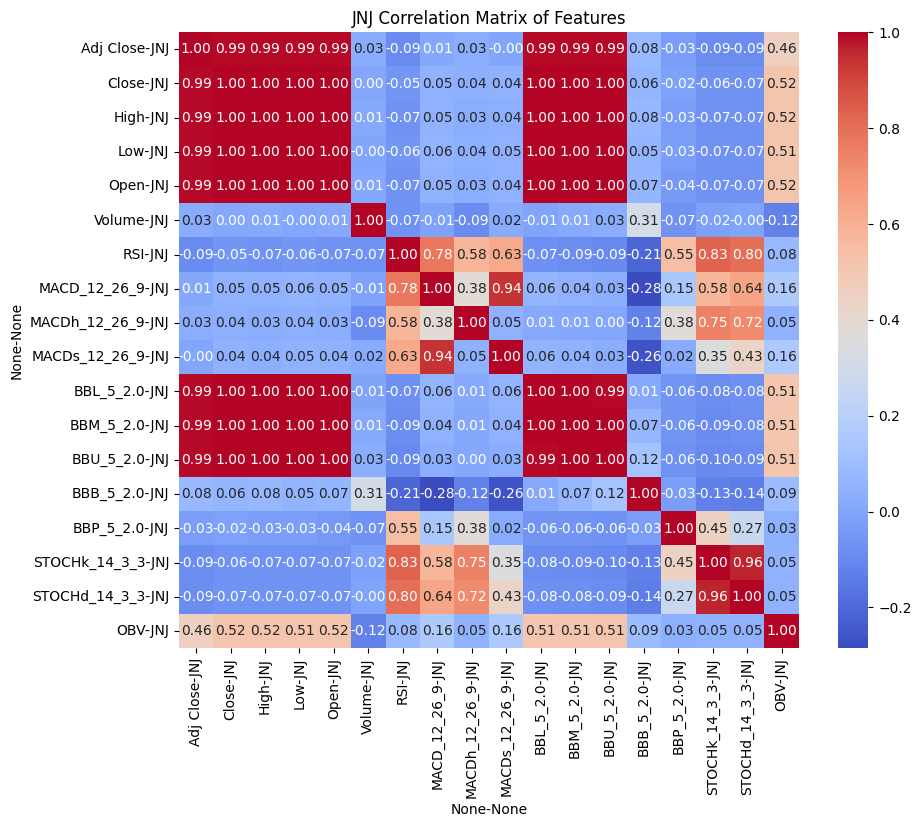

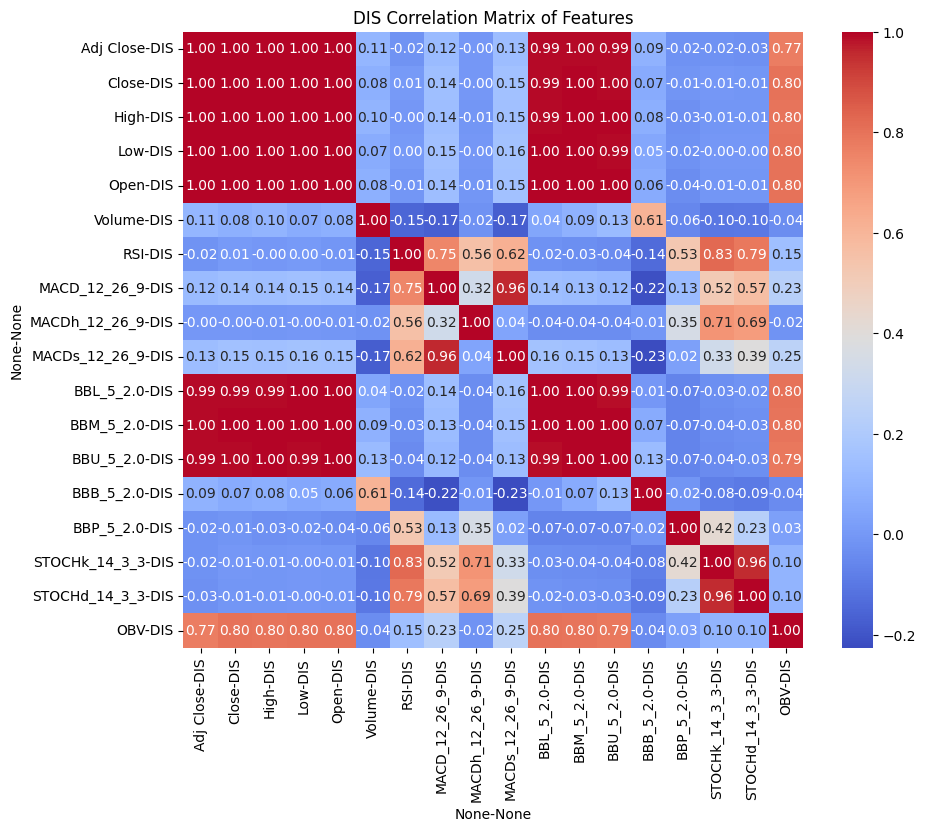

In [11]:
for tick in tickers:
  # Select features related to the current ticker
  idx = pd.IndexSlice
  feature_correlation_matrix = features.loc[:,idx[:,tick]].corr()
  # Plot the correlation matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(feature_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
  plt.title(f'{tick} Correlation Matrix of Features')
  plt.show()

# LSTM Model

In [12]:
## Import necessary libraries for modeling

# Split training and testing data
from sklearn.model_selection import train_test_split

# Modeling
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Model Visualization
from keras.utils import plot_model

# Ignore FutureWarnings and chained_assignment warnings
import warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-03-07 23:31:25.660620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 23:31:25.660667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 23:31:25.661403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 23:31:25.665794: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 23:31:26.333536: W tensorflow/compiler/tf2

## Split Training and Testing Data

In [13]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print('========= Train / Test Dataset =========')
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_price', y_price.shape)

========= Train / Test Dataset =========
X_train (436, 10, 108)
X_test (109, 10, 108)
y_train (436, 6)
y_test (109, 6)
y_price (545, 6)


## Training Model

In [14]:
def train(X_train, y_train, num_epochs, batch_size, learning_rate):
    model = Sequential()
    model.add(LSTM(units=X_train.shape[2], input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=y_train.shape[1]))  # output for optimal weights for next rebalance.
    
    model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, shuffle=False, validation_split=0.2, verbose=1)
    return model

num_epochs=128
batch_size=32
learning_rate=0.005
model = train(X_train, y_train, num_epochs, batch_size, learning_rate)

2024-03-07 23:31:27.015383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 23:31:27.030977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 23:31:27.031605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 23:31:27.033602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 23:31:27.034134: I external/local_xla/xla/stream_executor

Epoch 1/128


2024-03-07 23:31:31.216277: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1938 - loss: 0.4708 - val_accuracy: 0.1250 - val_loss: 0.2316
Epoch 2/128
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1635 - loss: 0.1247 - val_accuracy: 0.1364 - val_loss: 0.2072
Epoch 3/128
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2238 - loss: 0.1118 - val_accuracy: 0.1818 - val_loss: 0.1223
Epoch 4/128
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2027 - loss: 0.0936 - val_accuracy: 0.2159 - val_loss: 0.1109
Epoch 5/128
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2188 - loss: 0.0881 - val_accuracy: 0.1477 - val_loss: 0.1110
Epoch 6/128
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1805 - loss: 0.0842 - val_accuracy: 0.1477 - val_loss: 0.1059
Epoch 7/128
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2029 - loss: 0.0794 - val_accuracy: 0.1250 - val_loss: 0.1011
Epoch 8/128
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2151 - loss: 0.0766 - val_accuracy: 0.1477 - val_loss:

In [15]:
# Plot the model architecture
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
# Display summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 108)               │     93,744 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 6)                 │        654 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 283,196 (1.08 MB)

 Trainable params: 94,398 (368.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 188,798 (737.50 KB)

In [17]:
# Evaluate the model on the training data
eva_result = model.evaluate(X_train,y_train)
print(f"Loss on training data: {eva_result[0]:.4f}")
print(f"Model Accuracy: {eva_result[1]:.2%}")

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3949 - loss: 0.0548 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3875 - loss: 0.0553
Loss on training data: 0.0592
Model Accuracy: 33.94%


In [18]:
# Evaluate the model on the testing data
eva_result = model.evaluate(X_test,y_test)
print(f"Loss on testing data: {eva_result[0]:.4f}")
print(f"Model Accuracy: {eva_result[1]:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1686 - loss: 0.1095 
Loss on testing data: 0.1095
Model Accuracy: 15.60%


In [19]:
class Portfolio:
    @classmethod
    def portfolio_returns(cls, name, weights, prices):
        """
        Calculate portfolio returns and cumulative returns.

        Args:
            name (str): Name of the portfolio.
            weights (DataFrame): DataFrame containing portfolio weights.
            prices (DataFrame): DataFrame containing asset prices.

        Returns:
            DataFrame: DataFrame containing portfolio returns and cumulative returns.
        """

        returns = prices.pct_change().shift(-1)
        port = pd.DataFrame((returns*weights).sum(axis=1), columns=[f'{name}_returns'])
        port[f'{name}_cumrets'] = (port[f'{name}_returns']+1).cumprod()
        return port

# Result Analysis

In [20]:
# Extract the last len(y_test) rows from y_price for comparison
y_test_price = y_price[-1*len(y_test):]

# Calculate portfolio returns for the optimal portfolio (Testing Dataset)
optimal_portfolio = Portfolio.portfolio_returns('optimal', y_test, y_test_price)

# Calculate portfolio returns for the model's predictions
model_portfolio = Portfolio.portfolio_returns('model', model.predict(X_test), y_test_price)

# Calculate portfolio returns for the 1/N portfolio [or Equally Weighted]
one_over_n = np.ones(y_test_price.shape)
one_over_n[:,-1] = 0
one_over_n = one_over_n / len(tickers)
oneovern_portfolio = Portfolio.portfolio_returns('oneovern', one_over_n, y_test_price)

# Combine the portfolio returns into a single DataFrame for comparison
overall = optimal_portfolio.join(model_portfolio).join(oneovern_portfolio)

# Display overall returns
print(overall)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
            optimal_returns  optimal_cumrets  model_returns  model_cumrets  \
2021-11-05         0.009535         1.009535      -0.015968       0.984032   
2021-11-12         0.001555         1.011105      -0.023617       0.960791   
2021-11-19         0.000137         1.011243      -0.016114       0.945309   
2021-11-29         0.025129         1.036654       0.001076       0.946327   
2021-12-06         0.035510         1.073466       0.019891       0.965151   
...                     ...              ...            ...            ...   
2023-11-27         0.041554        26.036378       0.001542       1.005578   
2023-12-04         0.033130        26.898973       0.006659       1.012274   
2023-12-08         0.007253        27.094070      -0.002678       1.009563   
2023-12-15         0.062145        28.777838       0.018757       1.028500   
2023-12-22         0.000000        28.777838       0.000000       1.028500   

            oneovern_retu

In [21]:
#Mean return of portfolio
print('Mean Return')
overall[['optimal_returns', 'model_returns', 'oneovern_returns']].mean()

Mean Return


optimal_returns     0.031707
model_returns       0.000573
oneovern_returns   -0.000157
dtype: float64

In [22]:
#sharpe ratio of portfolio
print('Sharpe Ratio')
overall[['optimal_returns', 'model_returns', 'oneovern_returns']].mean() / overall[['optimal_returns', 'model_returns', 'oneovern_returns']].std()

Sharpe Ratio


optimal_returns     1.083371
model_returns       0.022655
oneovern_returns   -0.006064
dtype: float64

<Axes: >

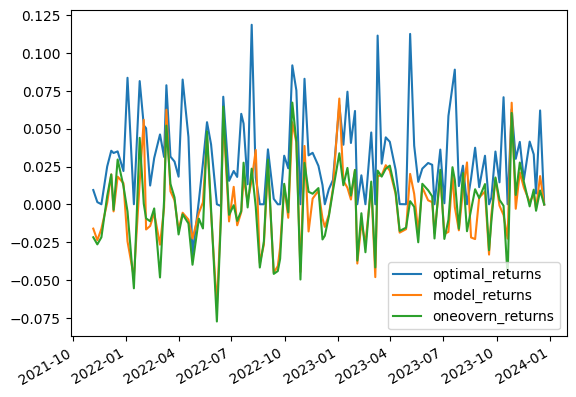

In [23]:
overall[['optimal_returns', 'model_returns', 'oneovern_returns']].plot()

<Axes: >

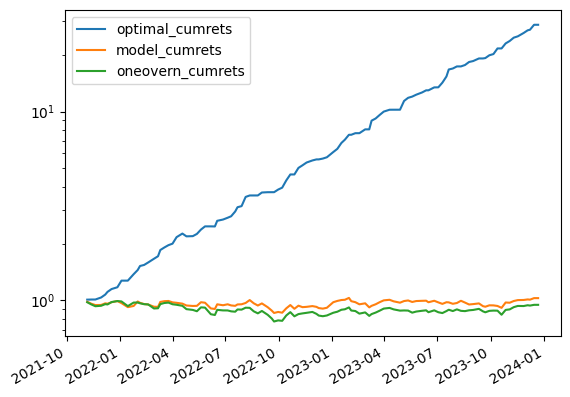

In [24]:
overall[['optimal_cumrets', 'model_cumrets', 'oneovern_cumrets']].plot(logy=True)